## Importando bibliotecas

In [119]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import sys
from util import *
import gc
import pickle

import warnings

# Ignorar todos os warnings
warnings.filterwarnings("ignore")

## Lendo os dados

In [120]:
df = pd.read_csv("../data/raw/Groceries_dataset.csv")

In [121]:
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


## Entendimento dos dados

In [122]:
print(df.shape)


(38765, 3)


In [123]:
metadados_compras = generate_metadata(df=df, ids=['Member_number'],targets=[''], orderby='PC_NULOS')
metadados_compras

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,Member_number,ID,0,0.0,3898,int64
1,Date,Explicativa,0,0.0,728,object
2,itemDescription,Explicativa,0,0.0,167,object


## Análises

### 1. Análise Temporal

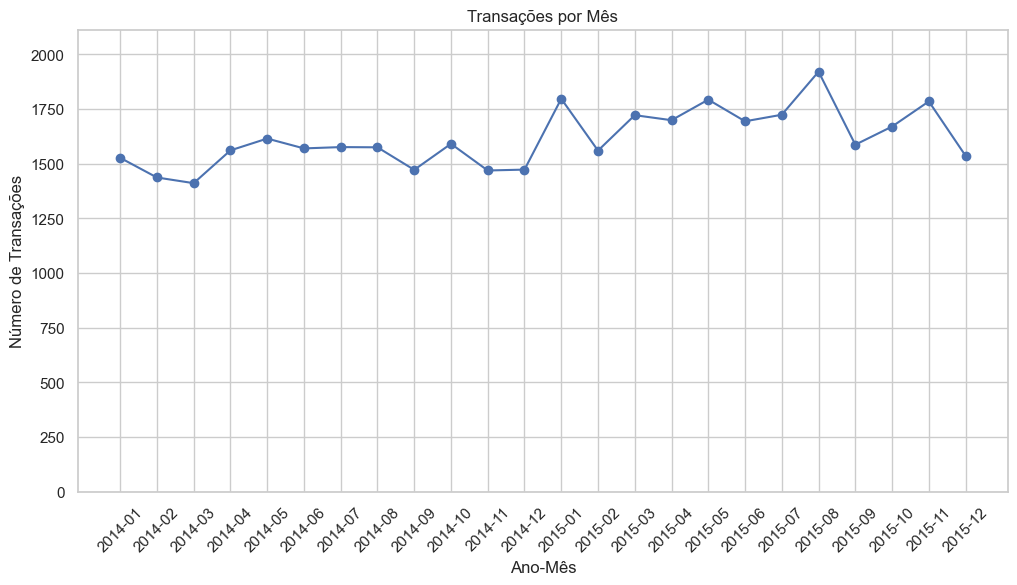

In [124]:
# Converter 'Date' para datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extrair ano, mês e dia
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Frequência de transações por mês/ano
transacoes_por_mes = df.groupby(['Year', 'Month']).size().reset_index(name='Count')

# Criar coluna Year-Month para o eixo X
transacoes_por_mes['Year-Month'] = transacoes_por_mes['Year'].astype(str) + '-' + transacoes_por_mes['Month'].astype(str).str.zfill(2)

# Plotar
plt.figure(figsize=(12, 6))
plt.plot(transacoes_por_mes['Year-Month'], transacoes_por_mes['Count'], marker='o')

# Ajustar eixo Y para começar em 0
plt.ylim(0, transacoes_por_mes['Count'].max() * 1.1)  # 10% acima do valor máximo

plt.title('Transações por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Número de Transações')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 2. Análise de Itens

itemDescription
whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: count, dtype: int64


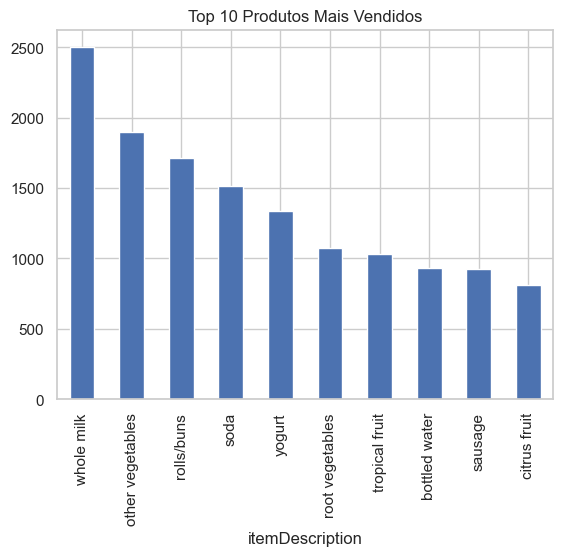

itemDescription
whisky                   8
salad dressing           6
frozen chicken           5
make up remover          5
toilet cleaner           5
rubbing alcohol          5
bags                     4
baby cosmetics           3
kitchen utensil          1
preservation products    1
Name: count, dtype: int64


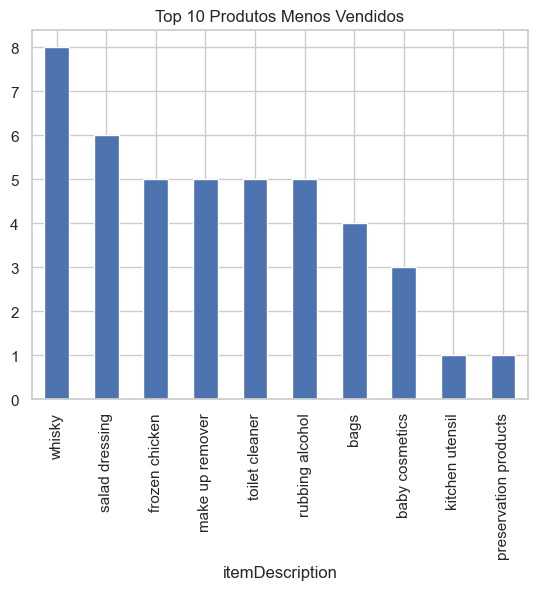

In [125]:
# Top 10 produtos mais vendidos
top_produtos = df['itemDescription'].value_counts().head(10)
print(top_produtos)

# Gráfico de barras
top_produtos.plot(kind='bar', title='Top 10 Produtos Mais Vendidos')
plt.show()

# Produtos menos vendidos (opcional)
produtos_raros = df['itemDescription'].value_counts().tail(10)
print(produtos_raros)

# Gráfico de barras
produtos_raros.plot(kind='bar', title='Top 10 Produtos Menos Vendidos')
plt.show()

### 3. Análise RFM (Recência, Frequência, Valor Monetário)

In [126]:
# Data de referência (última data disponível + 1 dia)
data_referencia = df['Date'].max() + pd.Timedelta(days=1)

In [127]:
# Agregar por cliente
rfm = df.groupby('Member_number').agg({
    'Date': lambda x: (data_referencia - x.max()).days,  # Recência (dias desde última compra)
    'Member_number': 'count',                           # Frequência (nº de transações)
    'itemDescription': 'count'                          # "Valor" (nº de itens comprados), se tivesse valor monetario entraria como soma
}).rename(columns={
    'Date': 'Recencia',
    'Member_number': 'Frequencia',
    'itemDescription': 'Valor'
}).reset_index()

print(rfm.head())

   Member_number  Recencia  Frequencia  Valor
0           1000        36          13     13
1           1001       243          12     12
2           1002       123           8      8
3           1003       324           8      8
4           1004        29          21     21


In [128]:
# Criar quartis para segmentação
quartis = rfm.quantile(q=[0.2, 0.4, 0.6, 0.8]).to_dict()

# Função para atribuir scores
def rfm_score(x, metric, quartis):
    if x <= quartis[metric][0.2]:
        return 1
    elif x <= quartis[metric][0.4]:
        return 2
    elif x <= quartis[metric][0.6]:
        return 3
    elif x <= quartis[metric][0.8]:
        return 4
    else:
        return 5

# Aplicar scores
rfm['R_Score'] = rfm['Recencia'].apply(rfm_score, args=('Recencia', quartis))
rfm['F_Score'] = rfm['Frequencia'].apply(rfm_score, args=('Frequencia', quartis))
rfm['V_Score'] = rfm['Valor'].apply(rfm_score, args=('Valor', quartis))

# Combinar scores (ex: R_Score=5, F_Score=5 -> "55")
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['V_Score'].astype(str)

print(rfm.head())

   Member_number  Recencia  Frequencia  Valor  R_Score  F_Score  V_Score  \
0           1000        36          13     13        1        4        4   
1           1001       243          12     12        4        4        4   
2           1002       123           8      8        3        2        2   
3           1003       324           8      8        4        2        2   
4           1004        29          21     21        1        5        5   

  RFM_Score  
0       144  
1       444  
2       322  
3       422  
4       155  


In [129]:
# Soma dos scores R + F + V (opcional, só se quiser usar em outra análise)
rfm['RFM_Sum'] = rfm[['R_Score', 'F_Score', 'V_Score']].sum(axis=1)

# Função de segmentação
def segmentar_cliente(row):
    score = row['RFM_Score']
    r, f, v = row['R_Score'], row['F_Score'], row['V_Score']

    if score == '555':
        return 'Campeões'
    elif r >= 4 and f >= 4:
        return 'Clientes Fiéis'
    elif f >= 4 and v >= 4:
        return 'Clientes Premium'
    elif r == 5:
        return 'Recente e Promissor'
    elif r >= 4 and f <= 2 and v <= 2:
        return 'Hibernantes'
    elif r <= 2 and f <= 2:
        return 'Risco de Perda'
    elif f == 1:
        return 'Clientes Raros'
    else:
        return 'Clientes Regulares'

# Aplicação correta da função
rfm['Segmento'] = rfm.apply(segmentar_cliente, axis=1)


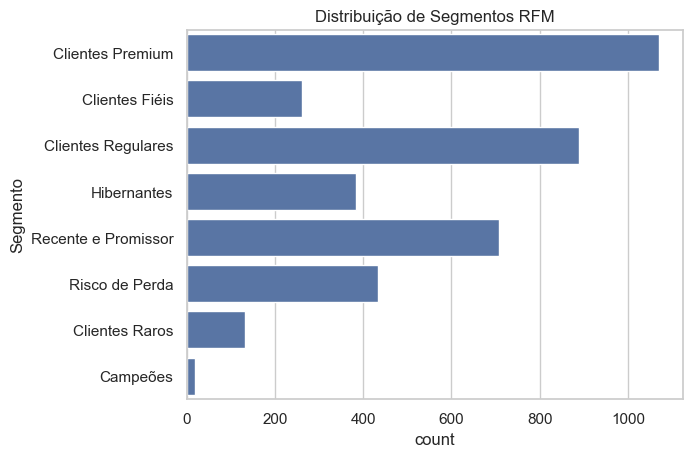

In [130]:
# Distribuição dos segmentos
sns.countplot(data=rfm, y='Segmento')
plt.title('Distribuição de Segmentos RFM')
plt.show()

### Recomendações por Segmento

| Segmento                | Características                                                     | Ações Recomendadas                                               |
|-------------------------|----------------------------------------------------------------------|------------------------------------------------------------------|
| **Campeões**            | Score 555, compram com frequência, gastam muito, são recentes       | Benefícios VIP, solicitar feedback, programas de fidelidade     |
| **Clientes Fiéis**      | Alta frequência e recência                                          | Recompensas exclusivas, retenção, upsell                        |
| **Clientes Premium**    | Gastam muito e compram com frequência                               | Produtos premium, cashback, atendimento personalizado           |
| **Recente e Promissor** | Compraram recentemente, mas ainda não com frequência nem valor alto | Nutrição de conteúdo, ofertas introdutórias, incentivo à compra |
| **Hibernantes**         | Altamente inativos, com baixo gasto e frequência                    | E-mails de reengajamento, campanhas sazonais, descontos         |
| **Risco de Perda**      | Não compram há muito tempo, baixo engajamento                       | Ofertas de reativação, pesquisas, campanha "sentimos sua falta" |
| **Clientes Raros**      | Compram raramente, geralmente de pouco valor                        | Ofertas pontuais, incentivo à frequência                        |
| **Clientes Regulares**  | Médios em tudo: nem os melhores nem os piores                       | Relacionamento, recomendações personalizadas                    |


In [134]:
df = df.drop(columns=['Year', 'Month'])

In [135]:
df['transaction_by_member'] = df['Member_number'].astype(str) + '_' + df['Date'].astype(str)

## Salvando base de dados

In [136]:
df.to_parquet("../data/processed/df_completo.parquet")